In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from acquire import get_mallcustomer_data
from summarize import df_summary
from prepare import data_prep
seed = 123

In [3]:
df = get_mallcustomer_data()
df_tips = sns.load_dataset('tips')
train, test = train_test_split(df, random_state = seed)

In [4]:
num_vars = list(train.select_dtypes('number').columns)
print('Scaling {}, and {}...'.format(', '.join(num_vars[:-1]), num_vars[:-1]))

Scaling age, annual_income, and ['age', 'annual_income']...


In [5]:
scaler = MinMaxScaler()
train[num_vars] = scaler.fit_transform(train[num_vars])
test[num_vars] = scaler.transform(test[num_vars])
print(train.describe())
print(test.describe())

              age  annual_income  spending_score
count  150.000000     150.000000      150.000000
mean     0.398974       0.364426        0.508027
std      0.277361       0.221008        0.254235
min      0.000000       0.000000        0.000000
25%      0.177885       0.204918        0.346939
50%      0.336538       0.368852        0.505102
75%      0.596154       0.506148        0.732143
max      1.000000       1.000000        1.000000
             age  annual_income  spending_score
count  50.000000      50.000000       50.000000
mean    0.406923       0.400492        0.484082
std     0.243108       0.196735        0.291561
min     0.000000       0.016393        0.000000
25%     0.250000       0.241803        0.224490
50%     0.355769       0.418033        0.443878
75%     0.572115       0.534836        0.732143
max     0.961538       0.721311        0.989796


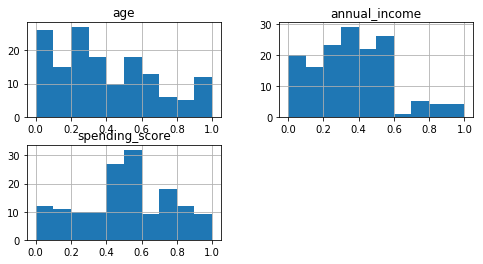

In [6]:
train.hist(figsize=(8,4), bins=10, log=False)
plt.show()

Gender

In [7]:
train.gender.value_counts()

Female    87
Male      63
Name: gender, dtype: int64

In [8]:
stats.ttest_ind(
    train[train.gender == 'Male'].spending_score.dropna(),
    train[train.gender == 'Female'].spending_score.dropna())

Ttest_indResult(statistic=-0.5668046160788702, pvalue=0.5717055394299067)

In [9]:
r, pval = stats.pearsonr(train.spending_score, train.age)
print("Pearson's R: {}, P-Value: {}".format(r, pval))

Pearson's R: -0.323429077595316, P-Value: 5.4116776021289656e-05


Binning into categorical for testing

In [10]:
train['spending_bins'] = pd.qcut(train['spending_score'], 4, labels=False)
train['spending_bins'].value_counts()

0    39
3    38
2    37
1    36
Name: spending_bins, dtype: int64

## Chi-Squared Testing


In [11]:
df_tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [12]:
pd.crosstab(df_tips["sex"], df_tips["smoker"], margins=True)

smoker,Yes,No,All
sex,,,
Male,60,97,157
Female,33,54,87
All,93,151,244


In [13]:
tbl = pd.crosstab(df_tips["sex"], df_tips["smoker"])
stat, p, dof, expected = stats.chi2_contingency(tbl)
prob = .95
critical = stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
print(p)

Independent (fail to reject H0)
0.925417020494423


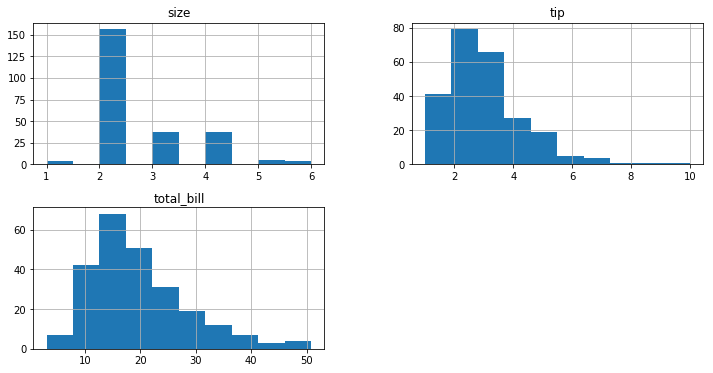

In [14]:
df_tips.hist(figsize=(12,6))
plt.show()

In [15]:
scaler = StandardScaler()
df_tips[['size','tip','total_bill']] = scaler.fit_transform(df_tips[['size','tip','total_bill']])
df_tips[['size','tip','total_bill']] = scaler.transform(df_tips[['size','tip','total_bill']])
print(df_tips.describe())

       total_bill         tip        size
count  244.000000  244.000000  244.000000
mean    -2.227106   -2.171407   -2.707344
std      0.112791    0.725706    1.055741
min     -2.438893   -3.219487   -4.449713
25%     -2.308679   -2.694996   -3.339692
50%     -2.252330   -2.222953   -3.339692
75%     -2.172099   -1.875478   -2.229671
max     -1.834039    1.500936    1.100394


In [16]:
df_tips['tip'] = pd.qcut(df_tips['tip'], 4, labels=False)
df_tips['tip'].value_counts()

0    78
3    61
2    61
1    44
Name: tip, dtype: int64

In [17]:
tbl = pd.crosstab(df_tips["sex"], df_tips["tip"])
stat, p, dof, expected = stats.chi2_contingency(tbl)
prob = .95
critical = stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
print(p)

Independent (fail to reject H0)
0.5524010015985761


In [18]:
r, pval = stats.pearsonr(df_tips.total_bill, df_tips.size)
print("Pearson's R: {}, P-Value: {}".format(r, pval))

Pearson's R: nan, P-Value: 1.0


In [19]:
import env

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'


df = pd.read_sql('''
                 SELECT p2.bathroomcnt, p2.bedroomcnt, p2.calculatedfinishedsquarefeet, 
                 p2.latitude, p2.longitude, p2.regionidcounty, p2.taxvaluedollarcnt, 
                 p2.landtaxvaluedollarcnt, p1.logerror
                    FROM predictions_2016 p1
                    LEFT JOIN properties_2016 p2  USING(parcelid)
                    WHERE bedroomcnt > 0 AND bathroomcnt > 0 AND unitcnt = 1 
                    AND latitude IS NOT NULL AND longitude IS NOT NULL;
                    '''
                 , get_connection('zillow'))

df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,regionidcounty,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror
0,2.0,3.0,1684.0,34280990.0,-118488536.0,3101.0,360170.0,237416.0,0.0276
1,3.0,2.0,2217.0,34136312.0,-118175032.0,3101.0,119906.0,57912.0,-0.0040
2,2.0,2.0,839.0,33755800.0,-118309000.0,3101.0,244880.0,73362.0,0.0218
3,4.0,4.0,3067.0,33870089.0,-118402768.0,3101.0,2447951.0,1567301.0,-0.2705
4,1.0,2.0,1297.0,33899475.0,-118212720.0,3101.0,111521.0,46972.0,0.0440


In [ ]:
train, test = train_test_split(df, random_state = seed)

In [ ]:
scaler = MinMaxScaler()
num_cols = train.drop(columns=['regionidcounty','bathroomcnt','bedroomcnt']).columns

train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])
print(train.describe())

In [ ]:
sns.swarmplot(x="regionidcounty", y="logerror", data=train, palette="Set2")
ax = sns.boxplot(x="regionidcounty", y="logerror", data=train,
        showcaps=True,boxprops={'facecolor':'None'},
        showfliers=True,whiskerprops={'linewidth':0})

In [ ]:
sns.set(style="whitegrid", palette="muted")

# "Melt" the dataset to "long-form" representation
df_melt = pd.melt(train_df[['regionidcounty','logerror','calculatedfinishedsquarefeet', 'latitude']], 
                  "regionidcounty", var_name="measurement")

plt.figure(figsize=(8,6))
# Draw a categorical scatterplot to show each observation
p = sns.swarmplot(x="measurement", y="value", hue="regionidcounty",
              palette=["r", "c", "y"], data=df_melt)
p.set(yscale="log")

plt.show()

In [ ]:
from pandas.tools.plotting import scatter_matrix
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

cmap = cm.get_cmap('gnuplot')
axes = pd.scatter_matrix(
    train[['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet']], marker='o', s=40,
    hist_kwds={'bins':15},  figsize=(9,9), cmap=cmap)
for ax in axes.flatten():
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))